In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from regions import Regions
import numpy as np
from astropy import units as u
from astropy.nddata import Cutout2D
import os
import random
from random import seed
import shutil
from skimage.io import imread,imshow
from skimage.transform import resize
from tqdm import tqdm

# Loading the fits file

In [2]:
hdul = fits.open('../../../data files/ngc0628_miri_f770w_anchored.fits')
regions = Regions.read('../../../data files/jwst-bubbles-v0p1.reg',format='ds9')
hdul.info()

Filename: ../../../data files/ngc0628_miri_f770w_anchored.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   (2968, 2938)   float64   


## Splitting the original image, bubble image and the masked image.

# Creating training images from cutouts

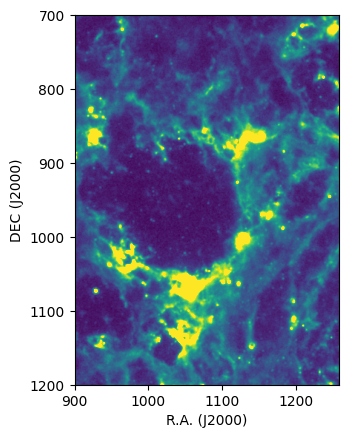

In [11]:
data = hdul[0].data
header = hdul[0].header

#Perform coordinate transforamtion:
wcs = WCS(header)

fig, ax = plt.subplots()
#Show map in World Coordinate System transform from axes
#plt.subplot(projection=wcs)


plt.ylim(1200,700)
plt.xlim(900,957.2647081455012+300)
plt.ylabel('DEC (J2000)')
plt.xlabel('R.A. (J2000)')
ax.imshow(data, vmin=0, vmax=7)

# for i,region in enumerate(regions[100:250]):
#     pixel_region = region.to_pixel(wcs)
#     if region == regions[132]:
#         position = (pixel_region.center.x,pixel_region.center.y)
#         size = u.Quantity((300,300), u.pixel)
#         cutout = Cutout2D(data,position,size)
#         #cutout.plot_on_original(color='white')
#     pixel_region.plot(ax=ax)
plt.savefig('../../../Final Presentation/sample_slice_original.png')

In [9]:
# fig, ax = plt.subplots(figsize=(7,7))
# data_original = imread('./original.png/')
# plt.imshow(data_original)

# Multiple masks in a single input image when matrix elements go from 0 to 1

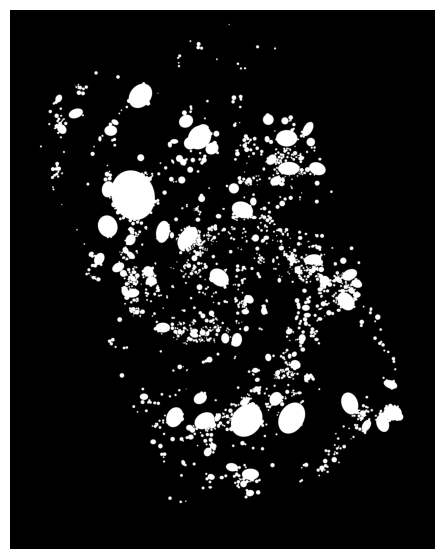

In [10]:
fig, ax = plt.subplots(figsize=(7,7))
shape = data.shape

final_matrix = np.zeros((shape))

for i,region in enumerate(regions):
    pixel_region = region.to_pixel(wcs)
    mask = pixel_region.to_mask(mode='exact')
    mask_matrix = mask.to_image(shape)
    final_matrix += mask_matrix
    
final_matrix[final_matrix > 1] = 1
#final_matrix[final_matrix == 0] = np.nan
plt.ylim(2500,150)
plt.xlim(500,2350)
plt.imshow(final_matrix,cmap='gray')
plt.gca().set_axis_off() # responsible for removing axes.
#plt.savefig('masked.png',bbox_inches='tight',pad_inches = 0)
#plt.colorbar()

<Axes: >

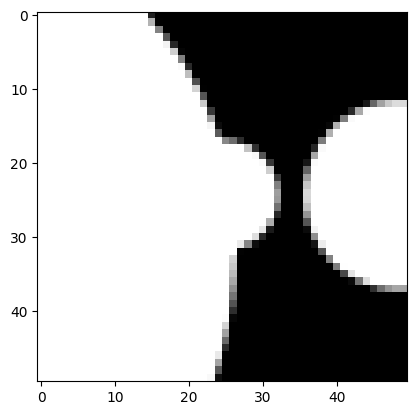

In [27]:
region = regions[6].to_pixel(wcs)
position = (region.center.x,region.center.y)
size = u.Quantity((50,50), u.pixel)

cutout = Cutout2D(final_matrix,position,size)

plt.imshow(cutout.data,cmap='gray')
cutout.plot_on_original(color='white')

# Creating dataset

In [18]:
dim  = 300
parent_folder = '../../../../../../Applications/PHYS499/dataset1695/'
#shutil.rmtree(parent_folder)
os.makedirs(parent_folder)
original_folder = f'{parent_folder}/original/'
os.mkdir(original_folder)
masked_folder = f'{parent_folder}/masked/'
os.mkdir(masked_folder)

for i,region in tqdm(enumerate(regions),total=len(regions)):
    pixel_region = region.to_pixel(wcs)
    position = (pixel_region.center.x,pixel_region.center.y)
    size = u.Quantity((dim,dim), u.pixel)
    
    cutout_original = Cutout2D(data,position,size)
    cutout_mask = Cutout2D(final_matrix,position,size)
    
    plt.imshow(cutout_original.data,vmin=0,vmax=7)
    plt.gca().set_axis_off() # responsible for removing axes.
    plt.savefig(f'{original_folder}/original_{i}.png',bbox_inches='tight',pad_inches = 0)
    plt.clf()
    
    plt.imshow(cutout_mask.data,cmap='gray')
    plt.gca().set_axis_off() # responsible for removing axes.
    plt.savefig(f'{masked_folder}/masked_{i}.png',bbox_inches='tight',pad_inches = 0)
    plt.clf()

100%|███████████████████████████████████████| 1695/1695 [02:03<00:00, 13.70it/s]


<Figure size 640x480 with 0 Axes>

## Pipeline the data into training 

In [19]:
num_of_originals = len([name for name in os.listdir(original_folder)])
num_of_masks = len([name for name in os.listdir(masked_folder)])


In [20]:
os.mkdir(f'{parent_folder}/stage1_train')

num_of_training_images = int(num_of_originals)

training_idx = next(os.walk(original_folder))[2] #all the ids
random.shuffle(training_idx) #random sampling of all the images ids

train_folder = f'{parent_folder}/stage1_train/'
for iterations in range(num_of_training_images):

    i = int(training_idx[iterations][9:-4])
    original_filename = f"original_{i}.png"
    dst_original_folder = f"{train_folder}/{original_filename}"
    os.mkdir(dst_original_folder)
    
    if (os.path.exists(dst_original_folder)):
        dst_image_folder = f"{dst_original_folder}/image"
        os.mkdir(dst_image_folder)

        dst_masked_folder = f"{dst_original_folder}/mask"
        os.mkdir(dst_masked_folder)

        
    masked_filename = f"masked_{i}.png"
    
    src_path_original = os.path.join(original_folder,original_filename)
    src_path_masked = os.path.join(masked_folder,masked_filename)
    
    dst_path_original = os.path.join(dst_image_folder,original_filename)
    dst_path_masked = os.path.join(dst_masked_folder,original_filename)
    
    shutil.copy(src_path_original,dst_path_original)
    shutil.copy(src_path_masked,dst_path_masked)
    
# shutil.rmtree(f'{parent_folder}/original/')
# shutil.rmtree(f'{parent_folder}/masked/')